In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, cross_val_predict
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

plt.rcParams['figure.figsize'] = (14, 10)
plt.rcParams['font.size'] = 24

df = pd.read_csv("data/raw/TreeDecision/chips.csv")
df

x         y  class
0    0.051267  0.699560      1
1   -0.092742  0.684940      1
2   -0.213710  0.692250      1
3   -0.375000  0.502190      1
4   -0.513250  0.465640      1
..        ...       ...    ...
113 -0.720620  0.538740      0
114 -0.593890  0.494880      0
115 -0.484450  0.999270      0
116 -0.006336  0.999270      0
117  0.632650 -0.030612      0

[118 rows x 3 columns]

In [2]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 118 entries, 0 to 117
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   x       118 non-null    float64
 1   y       118 non-null    float64
 2   class   118 non-null    int64  
dtypes: float64(2), int64(1)
memory usage: 2.9 KB


In [3]:
df["class"].value_counts()

0    60
1    58
Name: class, dtype: int64

In [4]:
def show_tree(tree):
    plt.figure(figsize=(20, 10))
    plot_tree(tree, filled=True, feature_names=["x", "y"], class_names=["0", "1"])
    plt.show()

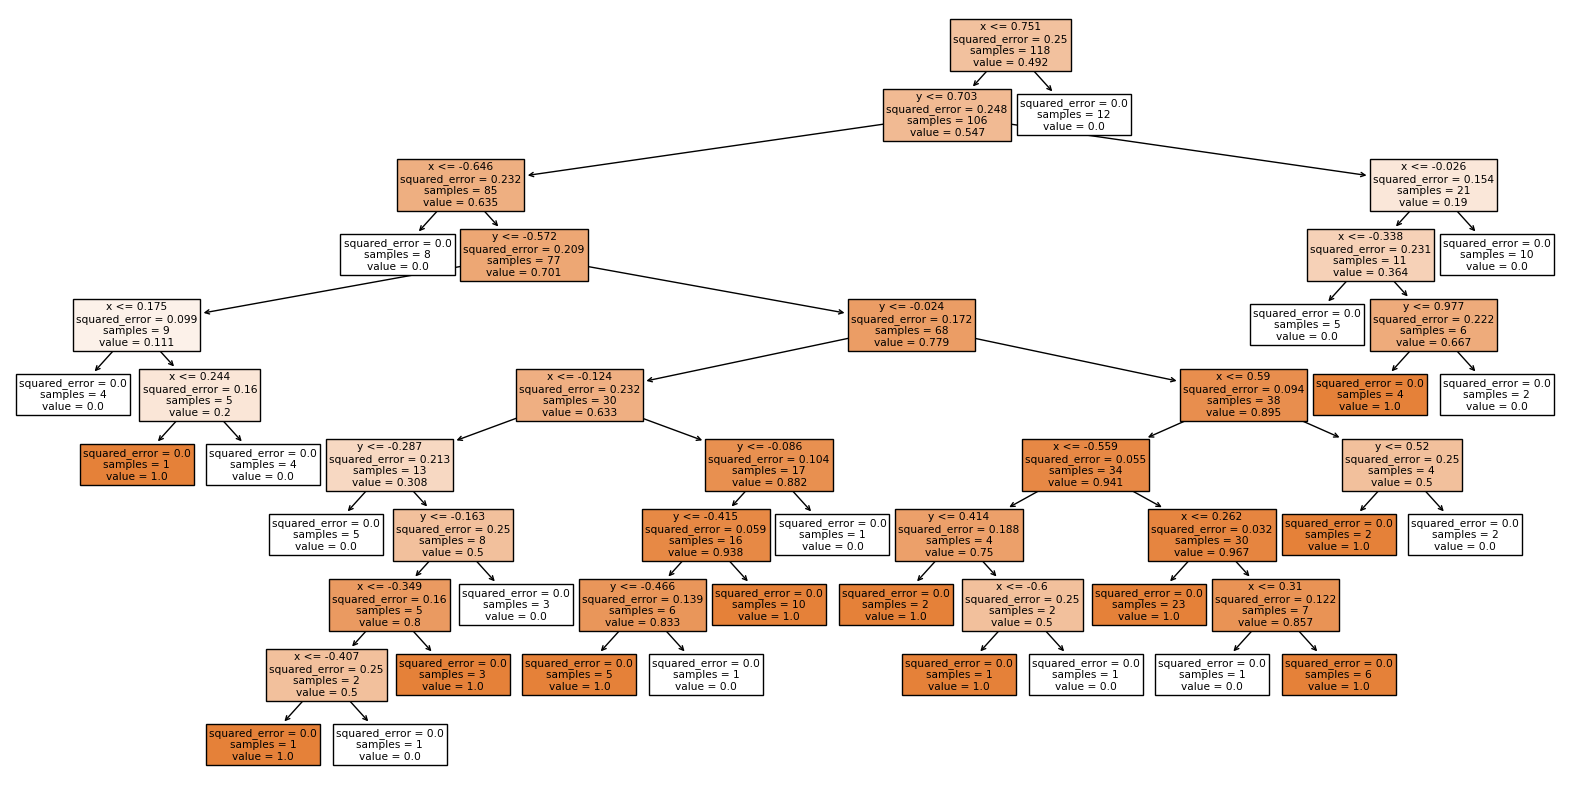

In [19]:
base_regressor = DecisionTreeRegressor(random_state = 0)

feature = df[["x", "y"]]
y = df["class"]

base_regressor.fit(feature, y)
show_tree(base_regressor)

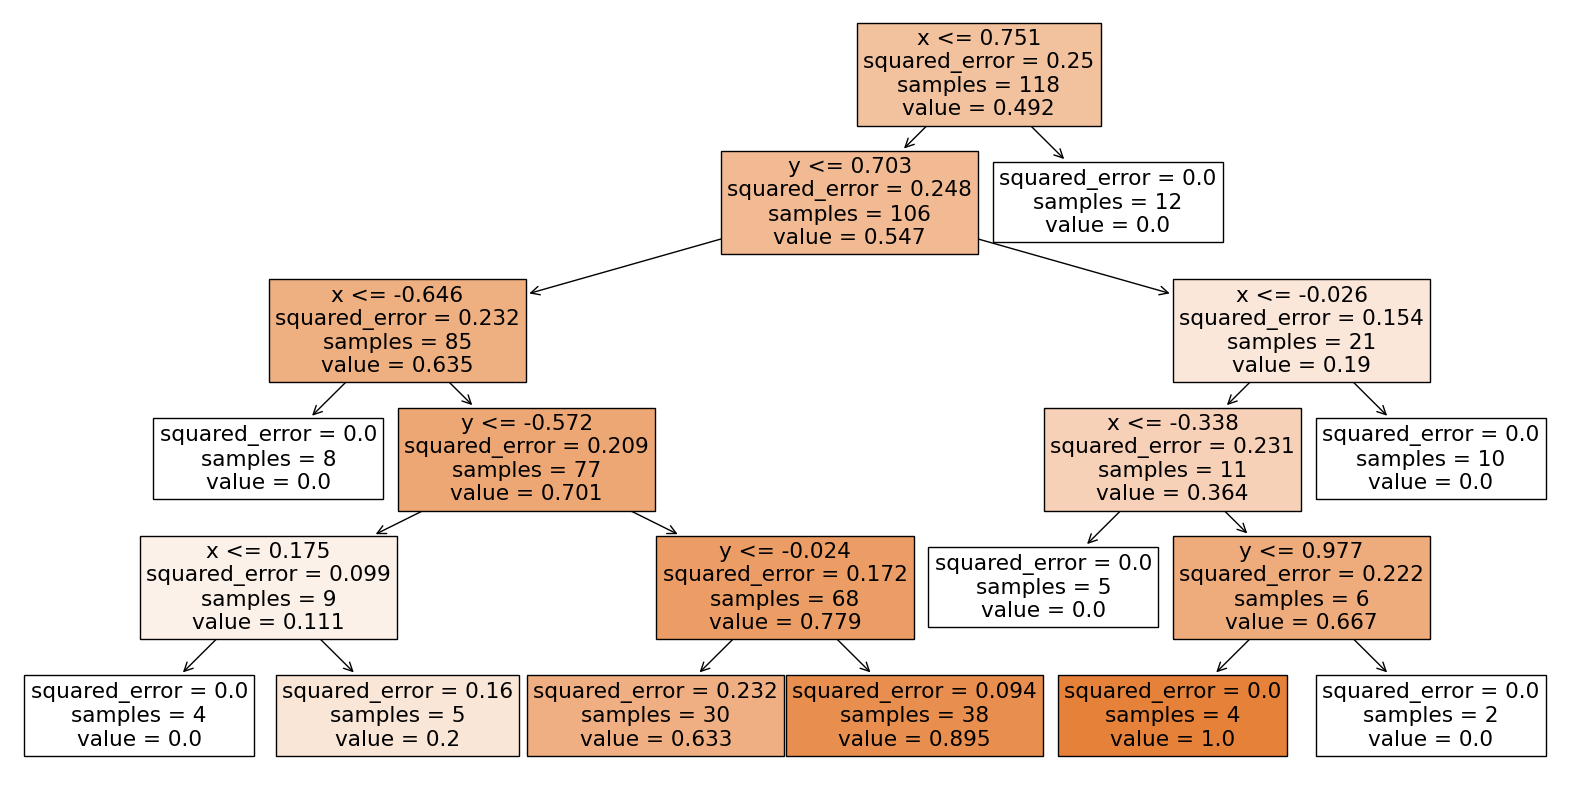

In [21]:
base_regressor2 = DecisionTreeRegressor(max_depth=5, random_state = 0)

base_regressor2.fit(feature, y)
show_tree(base_regressor2)

In [6]:
print(base_regressor.get_depth())

10


In [7]:
res = []
splits = 5
for train, test in StratifiedKFold(n_splits=splits, random_state=4, shuffle=True).split(feature, y):
    tmp = {"train": [], "test": [], "all": []}
    for i in range(1, base_regressor.get_depth() + 5):
        regressor = DecisionTreeRegressor(random_state = 0, max_depth=i)
        regressor.fit(feature.iloc[train], y.iloc[train])
        tmp["train"].append(regressor.score(feature.iloc[train], y.iloc[train]))
        tmp["test"].append(regressor.score(feature.iloc[test], y.iloc[test]))
        tmp["all"].append(regressor.score(feature, y))
    res.append(tmp)


In [8]:
def plot_res(data, size, x_label):
    colours = ['r', 'g', 'b', 'y', 'm']
    for i in range(min(len(colours), splits, len(data))):
        plt.plot(range(1, size), data[i]["all"], colours[i] + "-")
        plt.plot(range(1, size), data[i]["train"], colours[i] + "-.")
        plt.plot(range(1, size), data[i]["test"], colours[i] + ":")
    plt.legend(["all", "train", "test"])
    # plt.plot(range(1, base_regressor.get_depth() + 1), res, color='red')
    plt.title("Decision Tree")
    plt.xlabel(x_label)
    plt.ylabel('score')
    plt.grid(visible=True)
    plt.show()


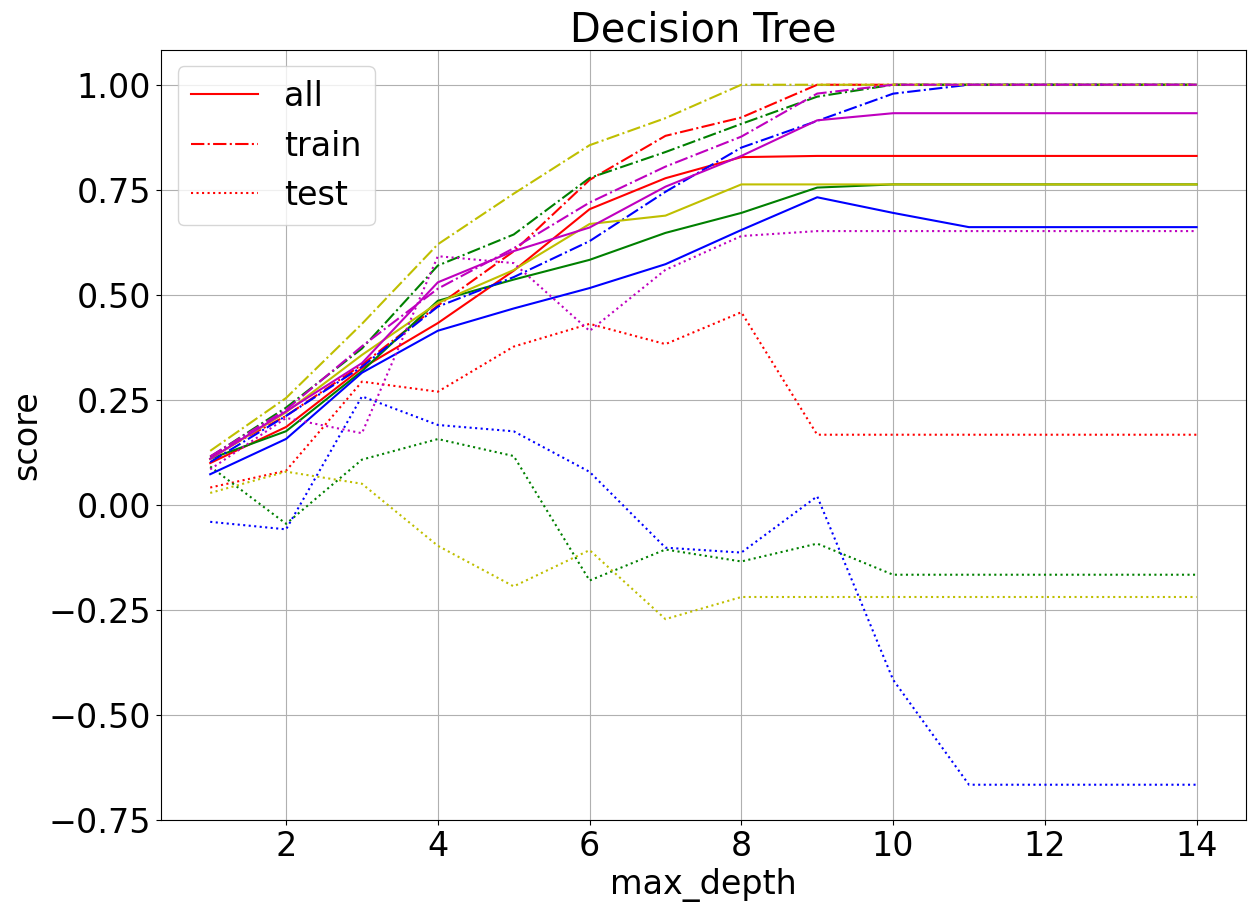

In [9]:
plot_res(res, base_regressor.get_depth() + 5, "max_depth")

In [10]:
count = 100
forest_res = []
for train, test in StratifiedKFold(n_splits=splits, random_state=4, shuffle=True).split(feature, y):
    tmp = {"train": [], "test": [], "all": []}
    for i in range(1, count):
        forest = RandomForestClassifier(n_estimators=i, random_state=0)
        forest.fit(feature.iloc[train], y.iloc[train])
        tmp["train"].append(forest.score(feature.iloc[train], y.iloc[train]))
        tmp["test"].append(forest.score(feature.iloc[test], y.iloc[test]))
        tmp["all"].append(forest.score(feature, y))
    forest_res.append(tmp)


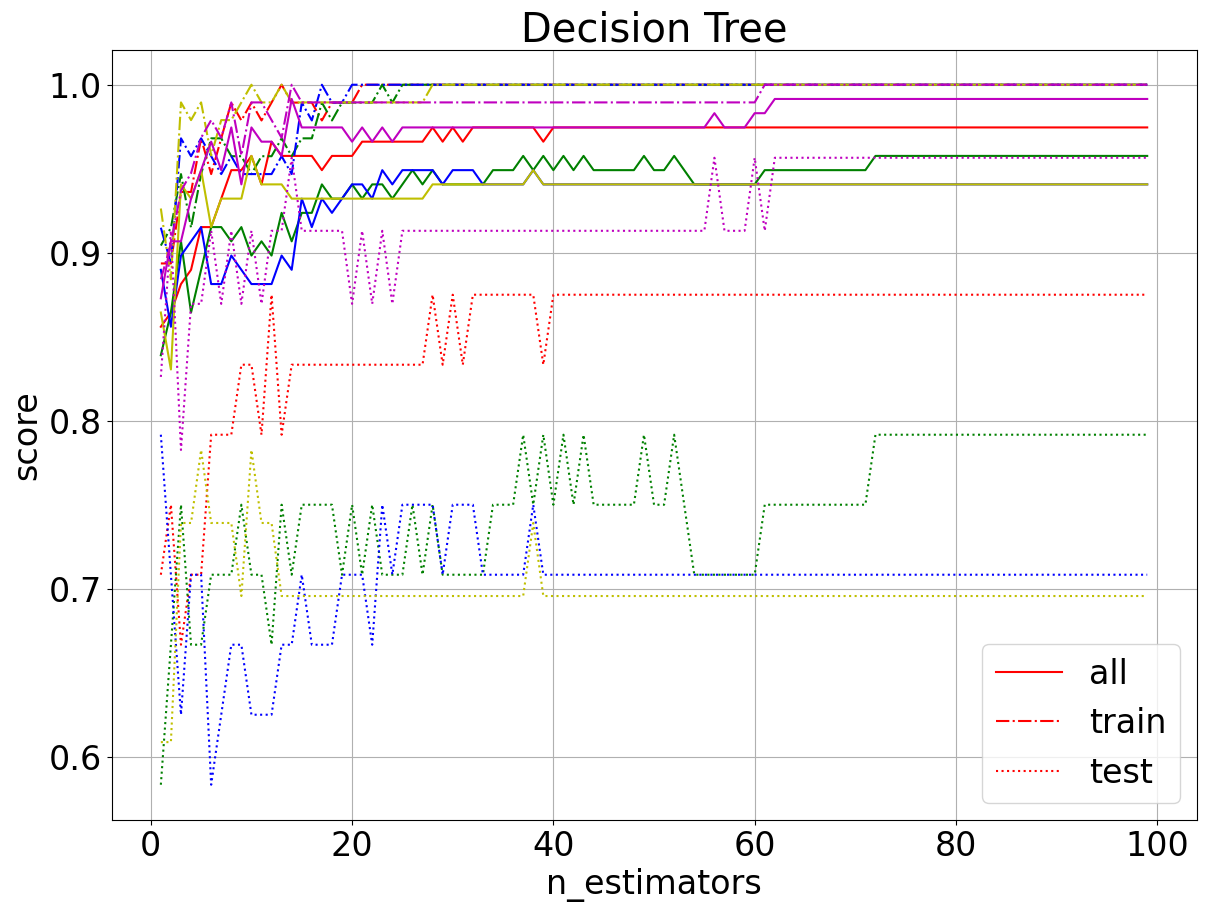

In [11]:
plot_res(forest_res, count, "n_estimators")

In [12]:
boosting_res = []
for train, test in StratifiedKFold(n_splits=splits, random_state=4, shuffle=True).split(feature, y):
    tmp = {"train": [], "test": [], "all": []}
    for i in range(1, count):
        forest = GradientBoostingClassifier(n_estimators=i, random_state=0)
        forest.fit(feature.iloc[train], y.iloc[train])
        tmp["train"].append(forest.score(feature.iloc[train], y.iloc[train]))
        tmp["test"].append(forest.score(feature.iloc[test], y.iloc[test]))
        tmp["all"].append(forest.score(feature, y))
    boosting_res.append(tmp)


In [13]:
def plot_res_subplots(pl, data, size, x_label, title):
    colours = ['r', 'g', 'b', 'y', 'm']
    for i in range(min(len(colours), splits)):
        pl.plot(range(1, size), data[i]["all"], colours[i] + "-")
        pl.plot(range(1, size), data[i]["train"], colours[i] + "-.")
        pl.plot(range(1, size), data[i]["test"], colours[i] + ":")
    pl.legend(["all", "train", "test"])
    # plt.plot(range(1, base_regressor.get_depth() + 1), res, color='red')
    pl.set_title(title)
    pl.set_xlabel(x_label)
    pl.set_ylabel('score')
    # pl.xlabel(x_label)
    # pl.ylabel('score')
    pl.grid(visible=True)

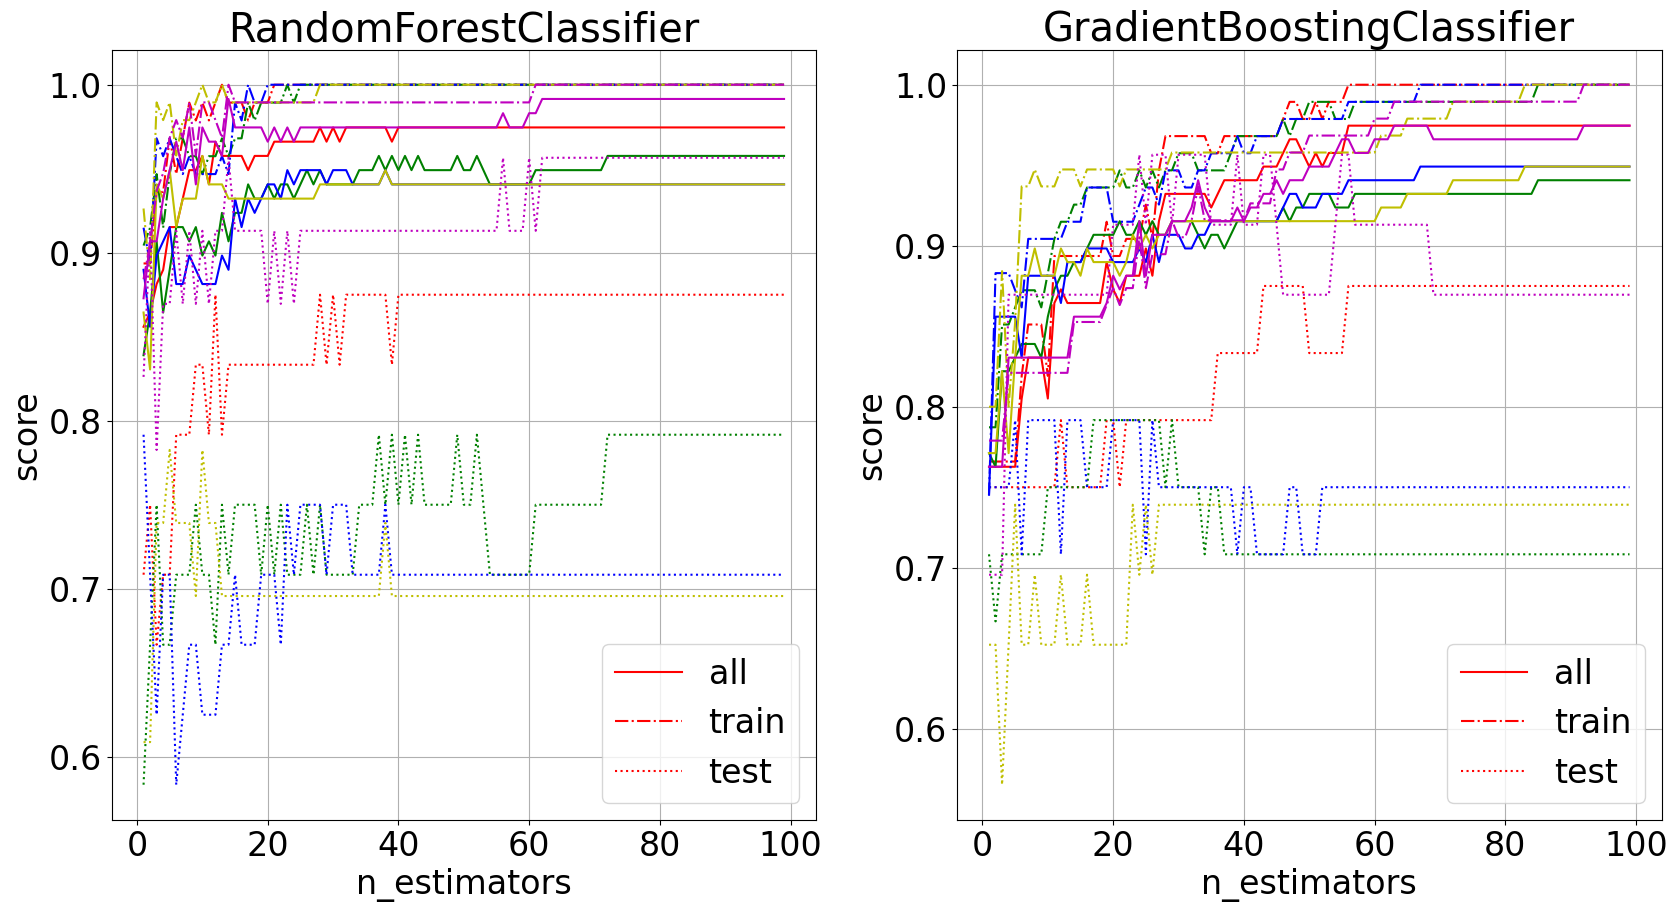

In [14]:
_, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
plot_res_subplots(ax1, forest_res, count, "n_estimators", "RandomForestClassifier")
plot_res_subplots(ax2, boosting_res, count, "n_estimators", "GradientBoostingClassifier")
plt.show()

In [15]:
cur = []

def rand(const):
    tmp = {"train": [], "test": [], "all": []}
    X_train, X_test, y_train, y_test = train_test_split(feature, y, test_size=0.2, random_state=4)
    for i in range(1, 150):
        clf = const(n_estimators=i, random_state=0)
        clf.fit(X_train, y_train)
        tmp["train"].append(clf.score(X_train, y_train))
        tmp["test"].append(clf.score(X_test, y_test))
        tmp["all"].append(clf.score(feature, y))
    return tmp
cur.append(rand(RandomForestClassifier))
cur.append(rand(GradientBoostingClassifier))

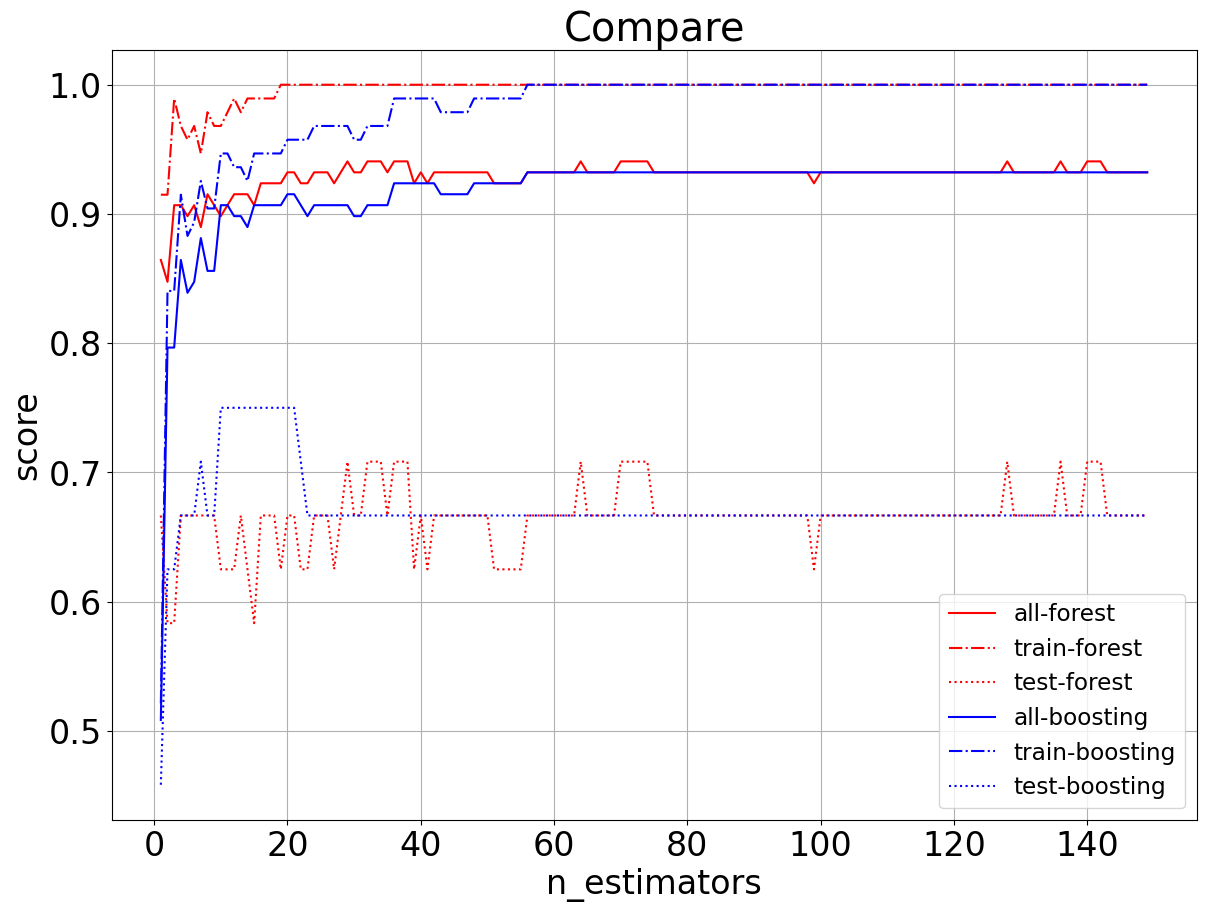

In [16]:
colours = ['r', 'g', 'b', 'y', 'm']
plt.plot(range(1, 150), cur[0]["all"], colours[0] + "-")
plt.plot(range(1, 150), cur[0]["train"], colours[0] + "-.")
plt.plot(range(1, 150), cur[0]["test"], colours[0] + ":")
plt.plot(range(1, 150), cur[1]["all"], colours[2] + "-")
plt.plot(range(1, 150), cur[1]["train"], colours[2] + "-.")
plt.plot(range(1, 150), cur[1]["test"], colours[2] + ":")
plt.legend(["all-forest", "train-forest", "test-forest", "all-boosting", "train-boosting", "test-boosting"], loc='lower right', fontsize='x-small')
plt.title("Compare")
plt.xlabel('n_estimators')
plt.ylabel('score')
plt.grid(visible=True)
plt.show()

In [17]:
def map_points(i):
    clf_forest = RandomForestClassifier(n_estimators=i, random_state=0)
    clf_boosting = GradientBoostingClassifier(n_estimators=i, random_state=0)
    clf_forest.fit(X_train.values, y_train.values)
    clf_boosting.fit(X_train.values, y_train.values)
    _, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))
    plt.suptitle("n_estimators = " + str(i))
    ax1.set_xlabel('x', fontsize=24)
    ax1.set_ylabel('y', fontsize=24)
    ax1.set_title("RandomForestClassifier", fontsize=16)
    ax2.set_xlabel('x', fontsize=24)
    ax2.set_ylabel('y', fontsize=24)
    ax2.set_title("GradientBoostingClassifier", fontsize=16)
    ax1.pcolormesh(xx, yy, clf_forest.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape), cmap='ocean')
    ax1.scatter(
        X_train.x, X_train.y, c=clf_forest.predict(X_train.values), s=100,
        cmap='autumn', edgecolors='navy', linewidth=2)
    ax1.scatter(
        X_test.x, X_test.y, c=clf_forest.predict(X_test.values), s=100,
        cmap='autumn', edgecolors='orange', linewidth=2)
    ax2.pcolormesh(xx, yy, clf_boosting.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape), cmap='ocean')
    ax2.scatter(
        X_train.x, X_train.y, c=clf_boosting.predict(X_train.values), s=100,
        cmap='autumn', edgecolors='navy', linewidth=2)
    ax2.scatter(
        X_test.x, X_test.y, c=clf_boosting.predict(X_test.values), s=100,
        cmap='autumn', edgecolors='orange', linewidth=2)

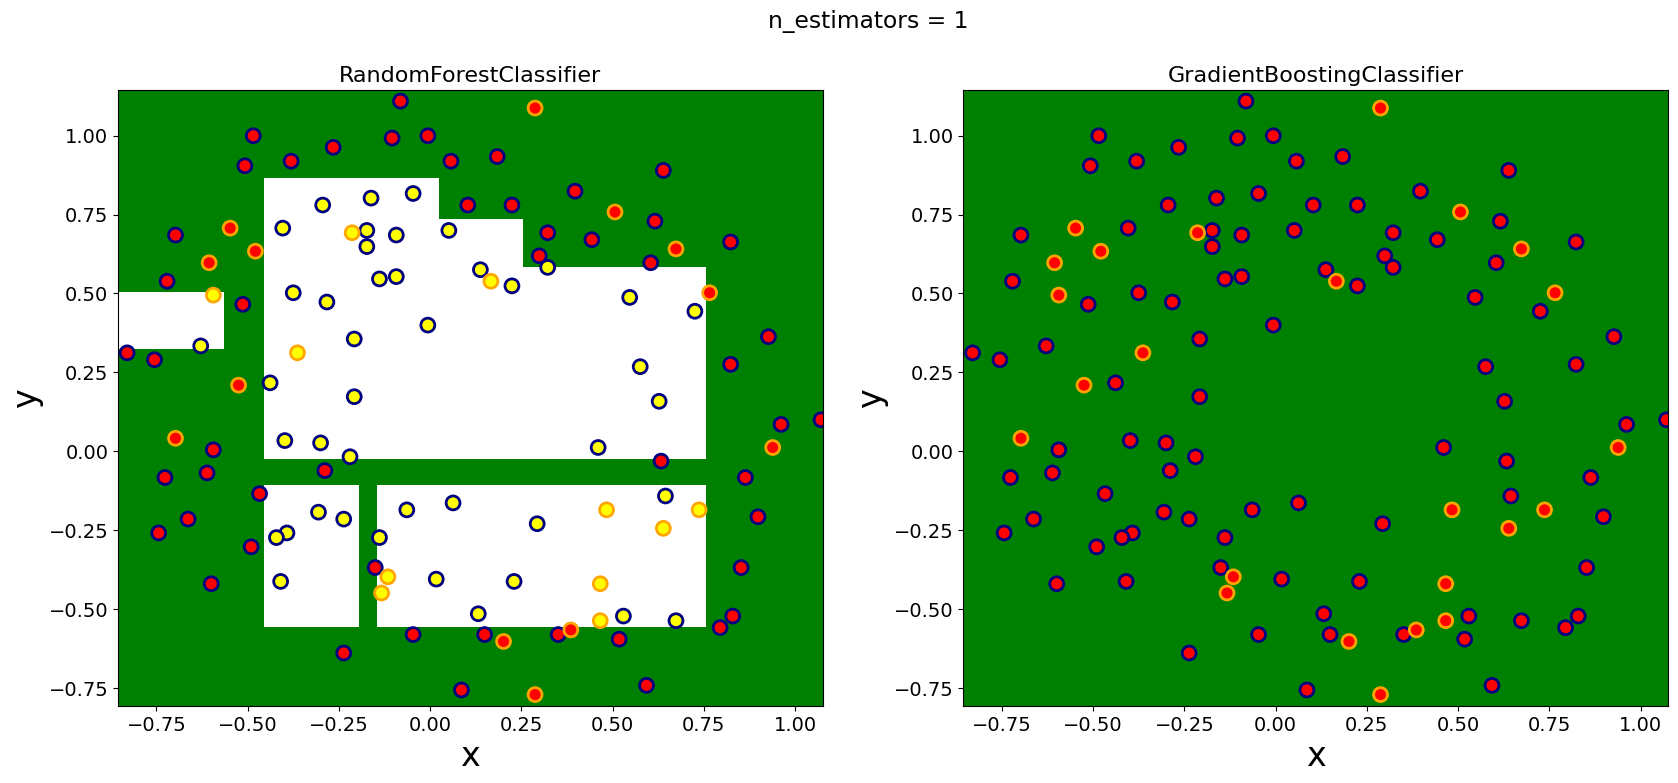

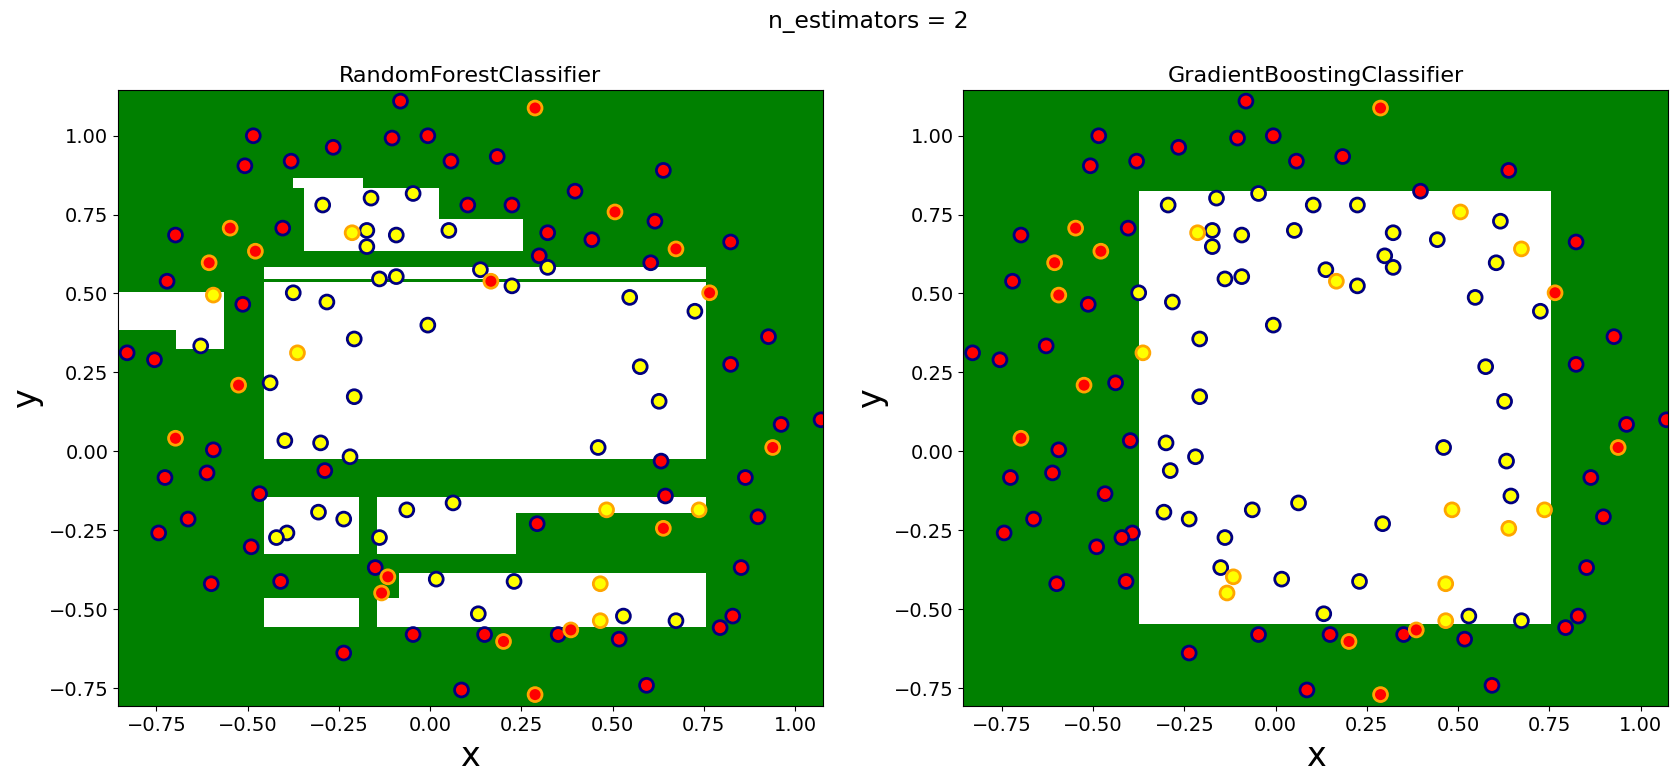

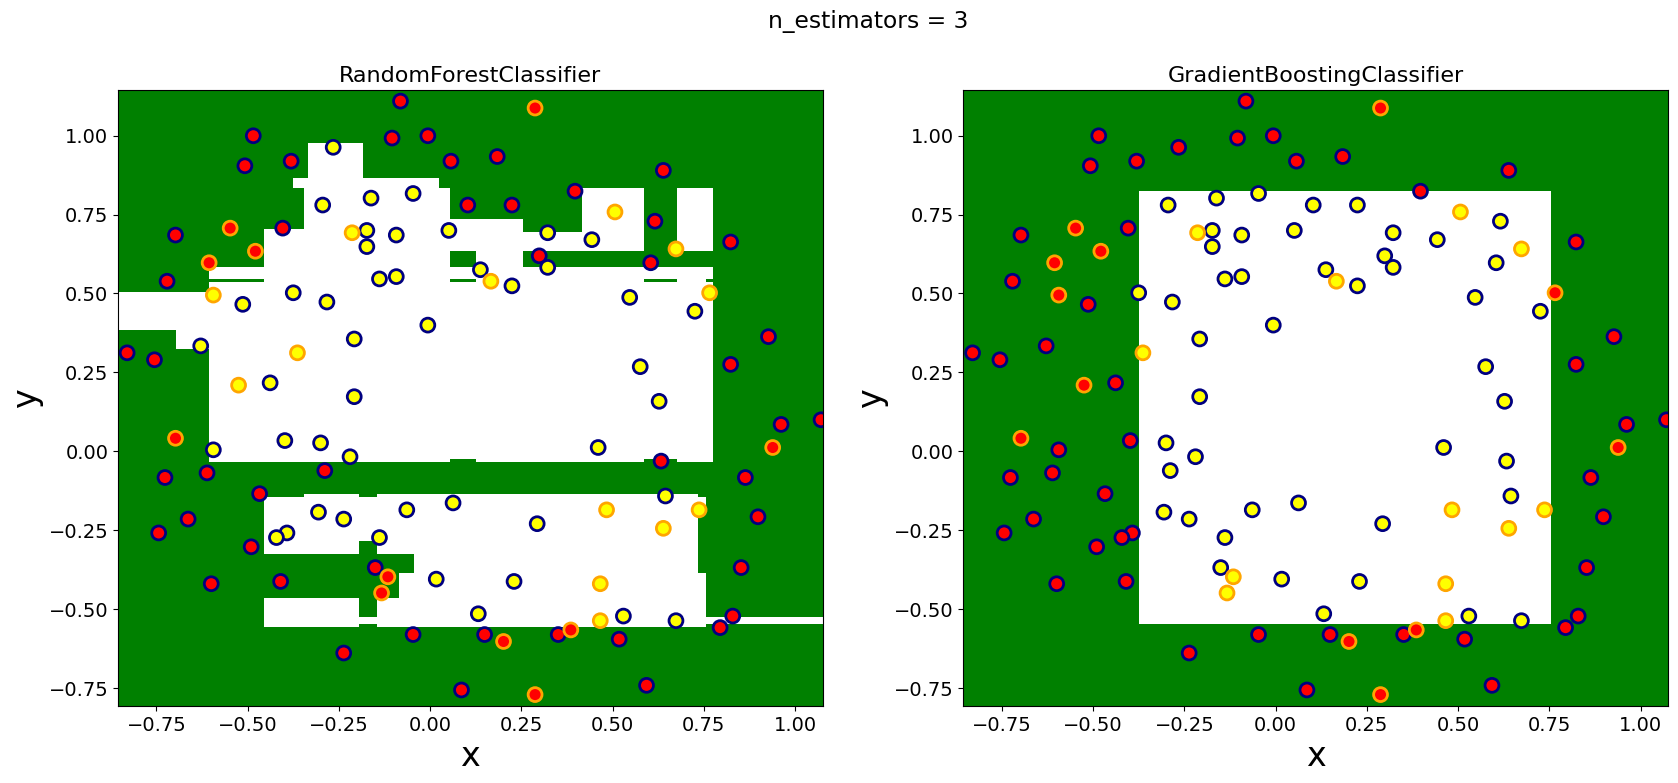

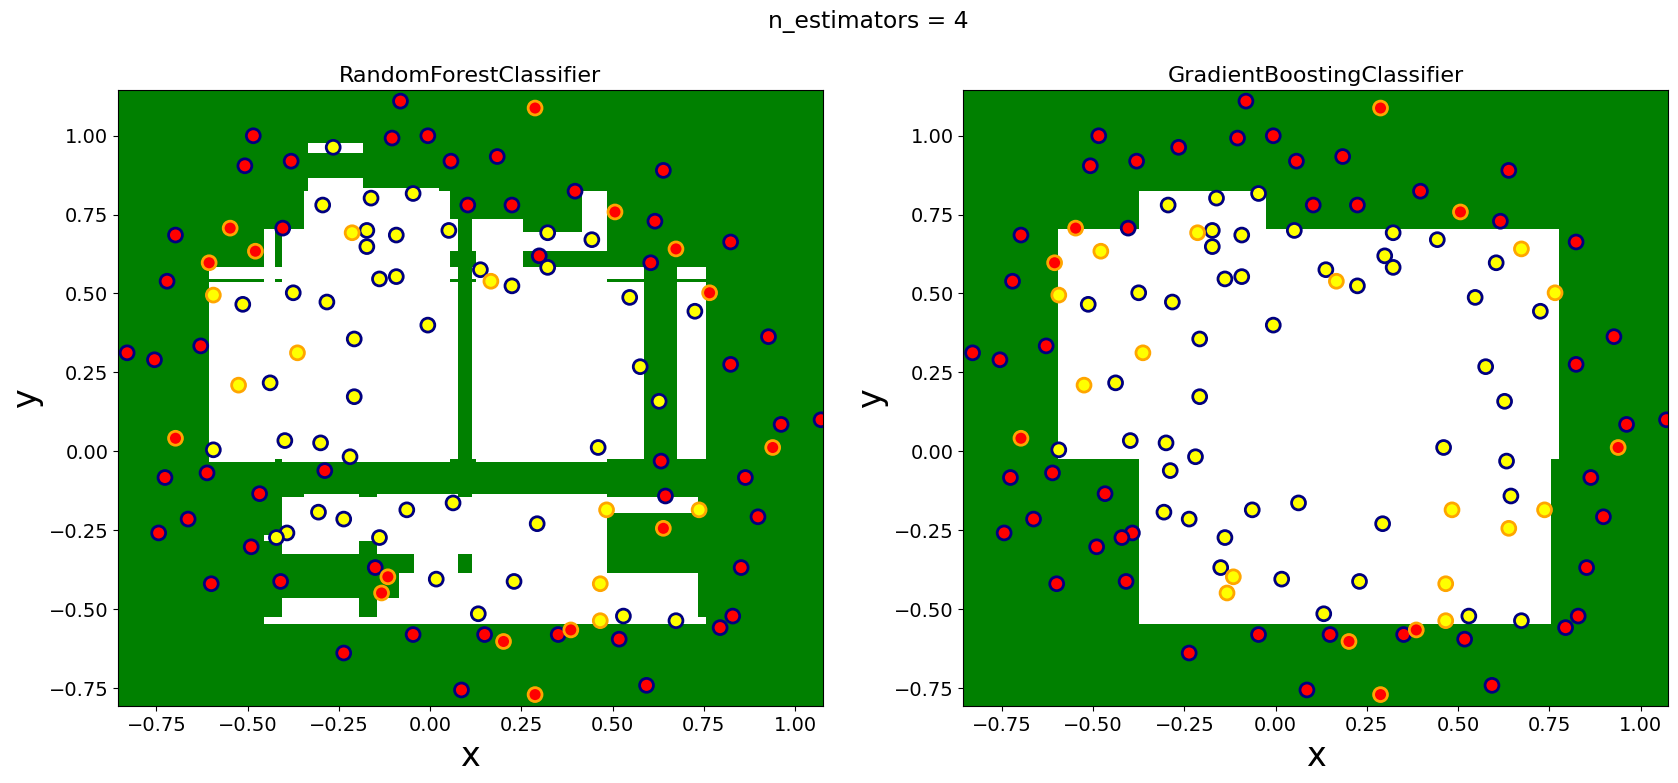

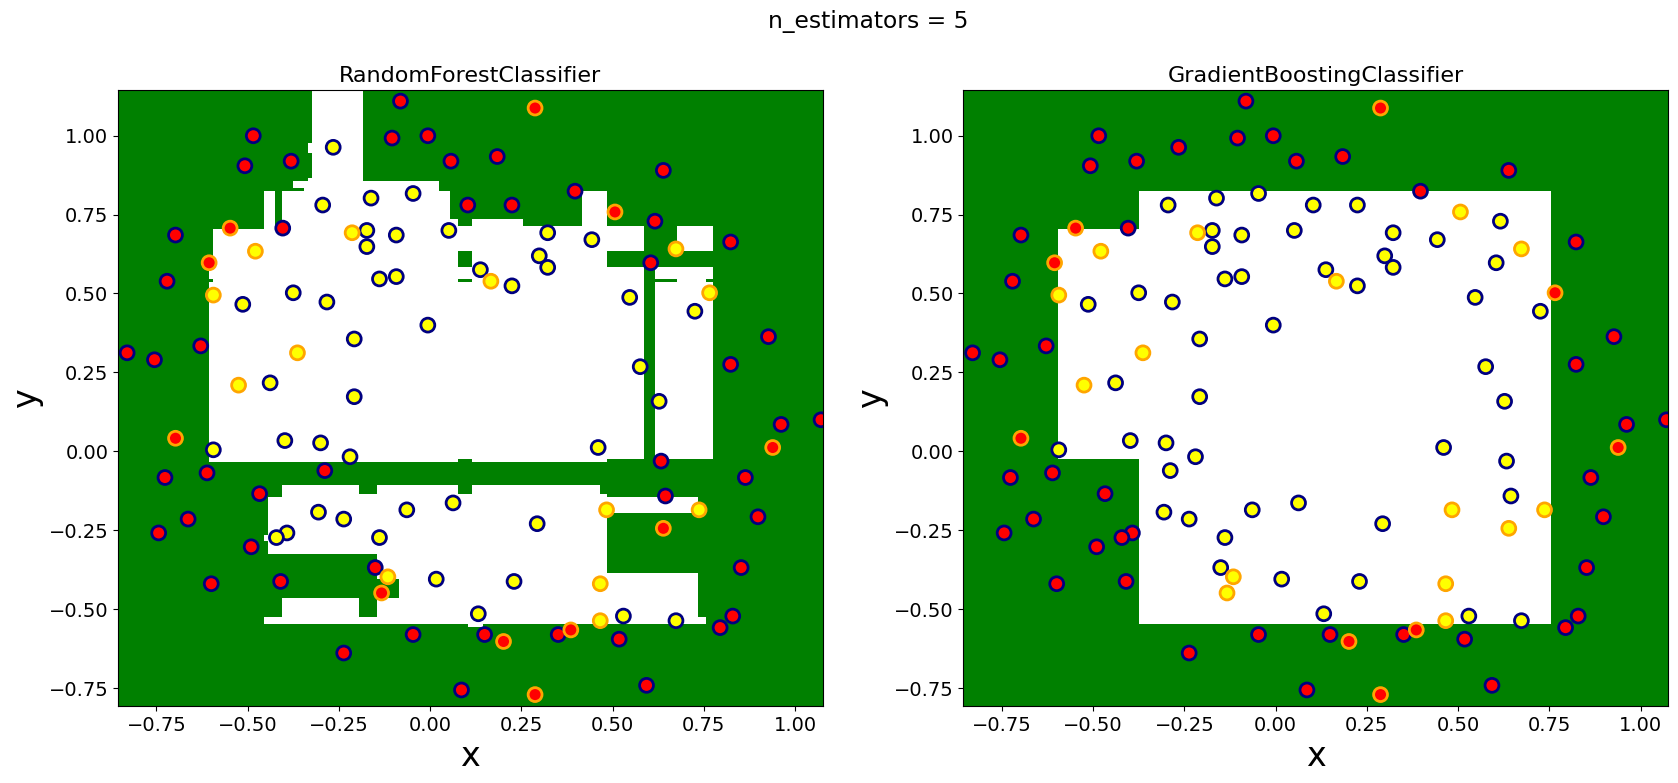

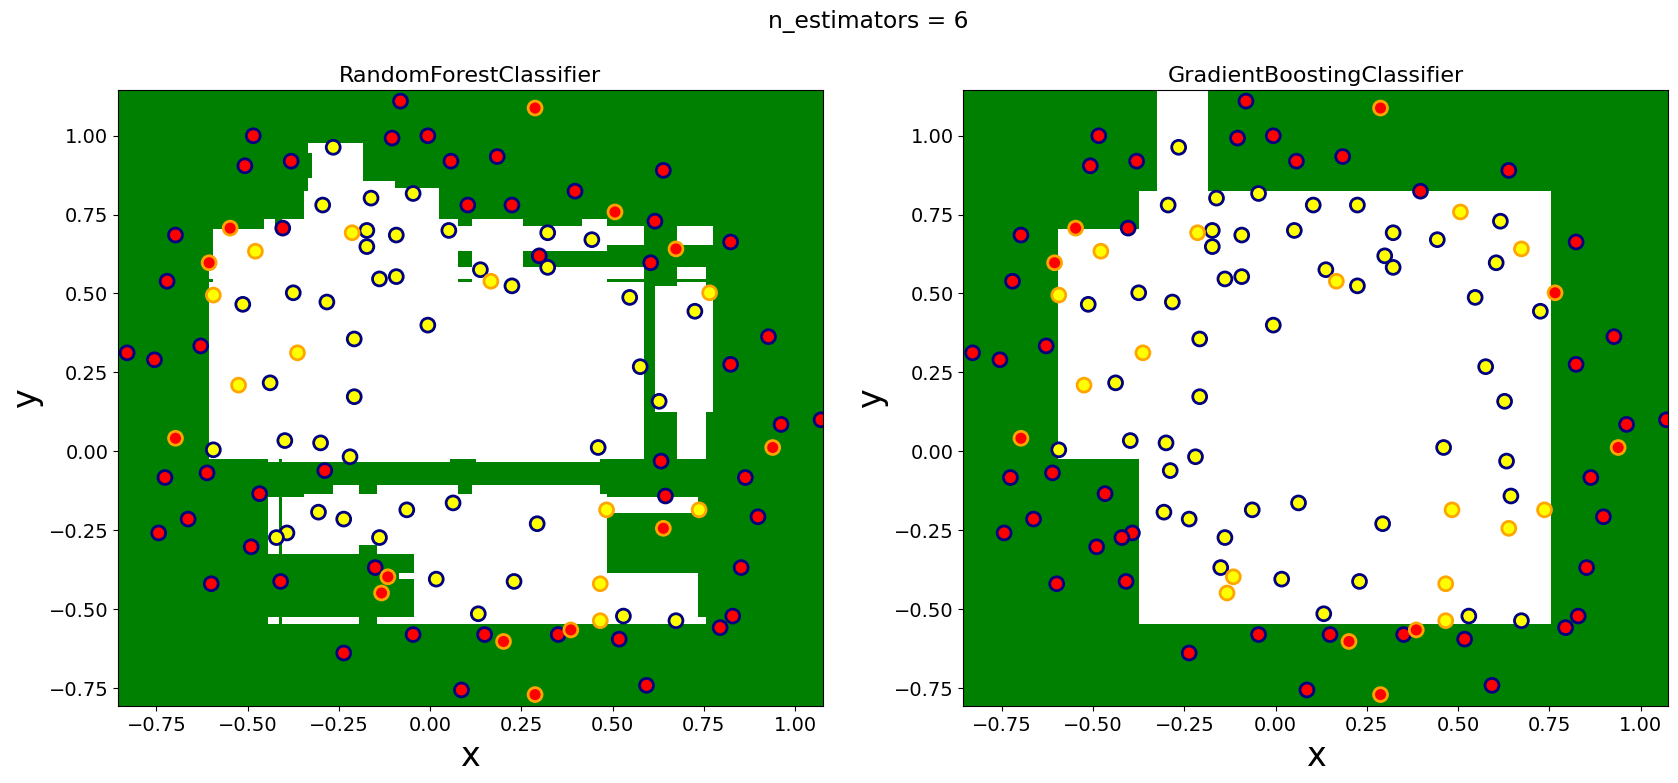

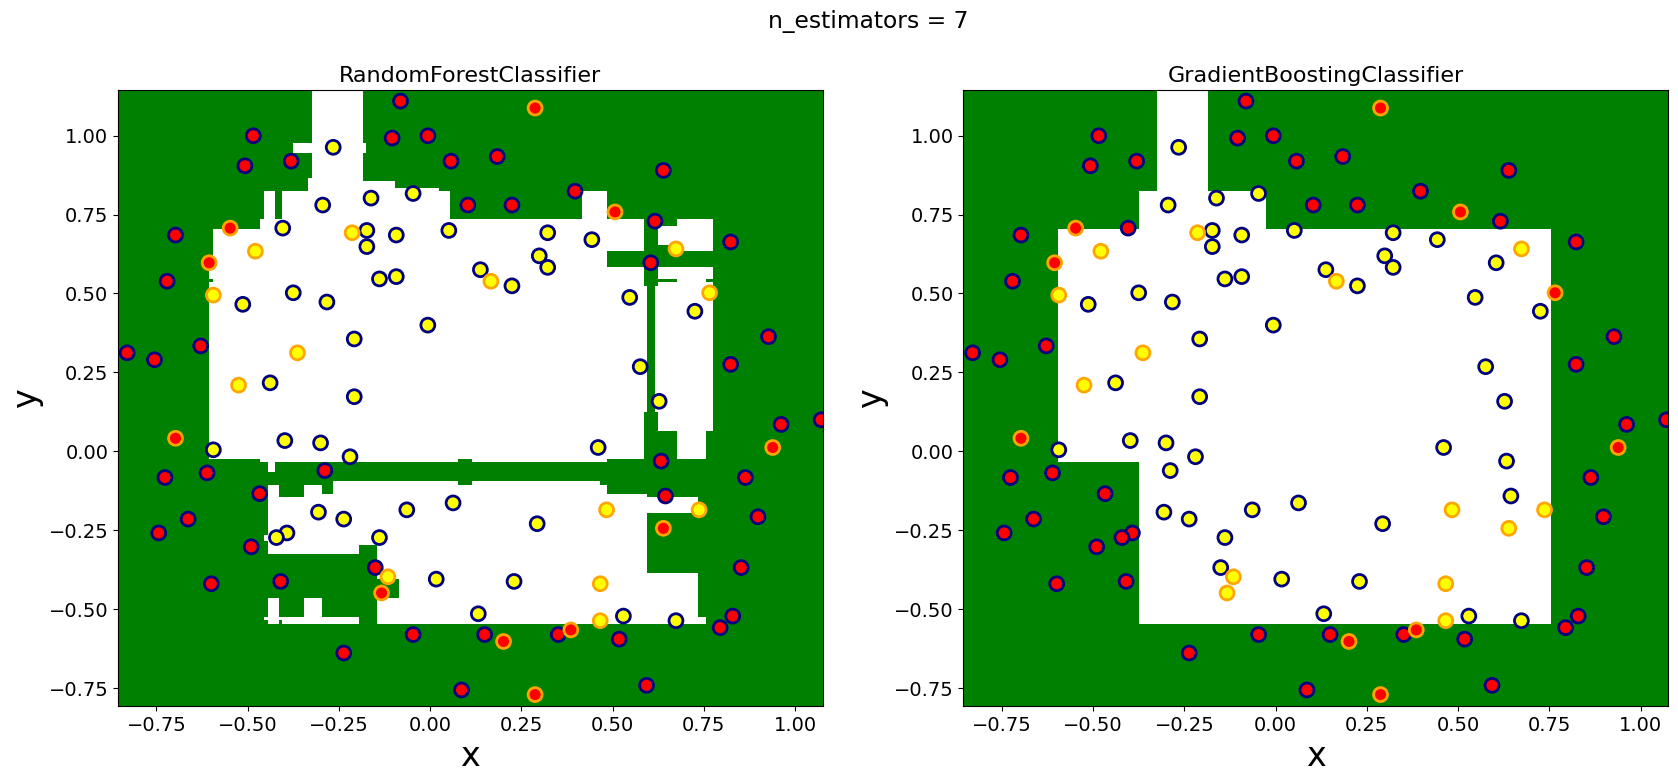

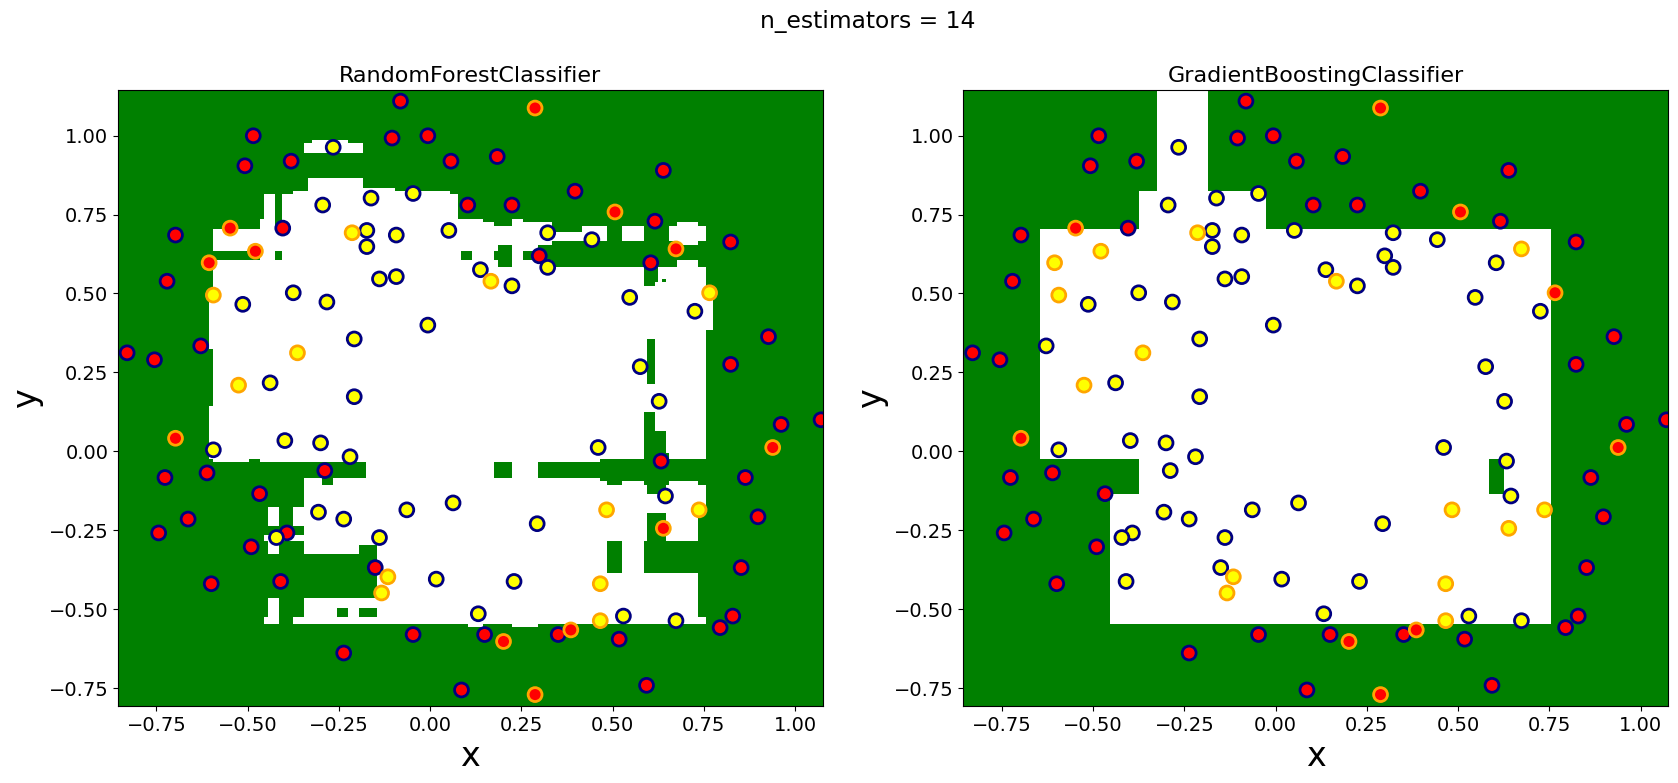

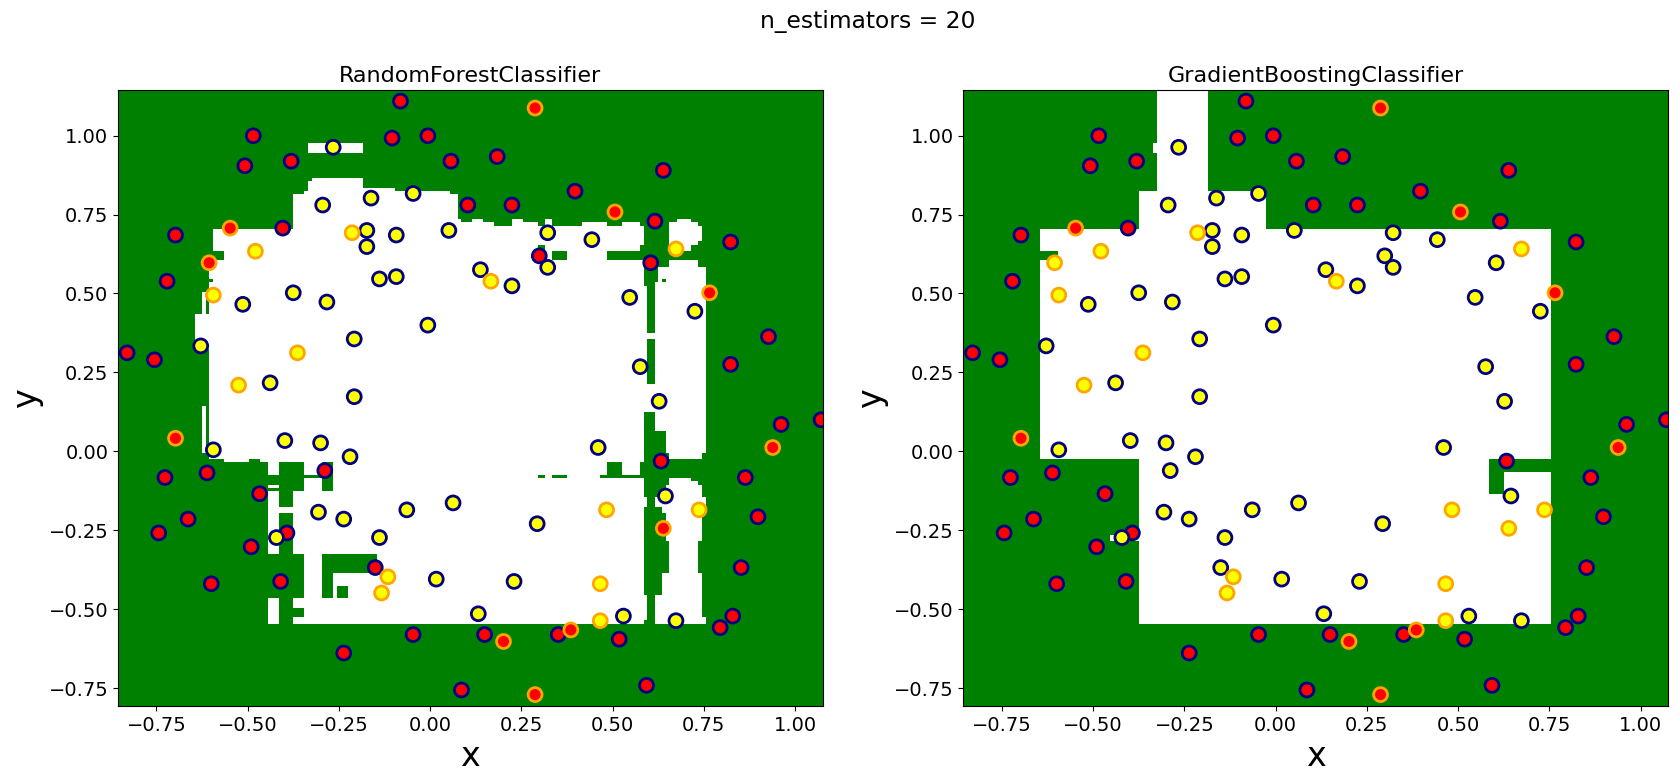

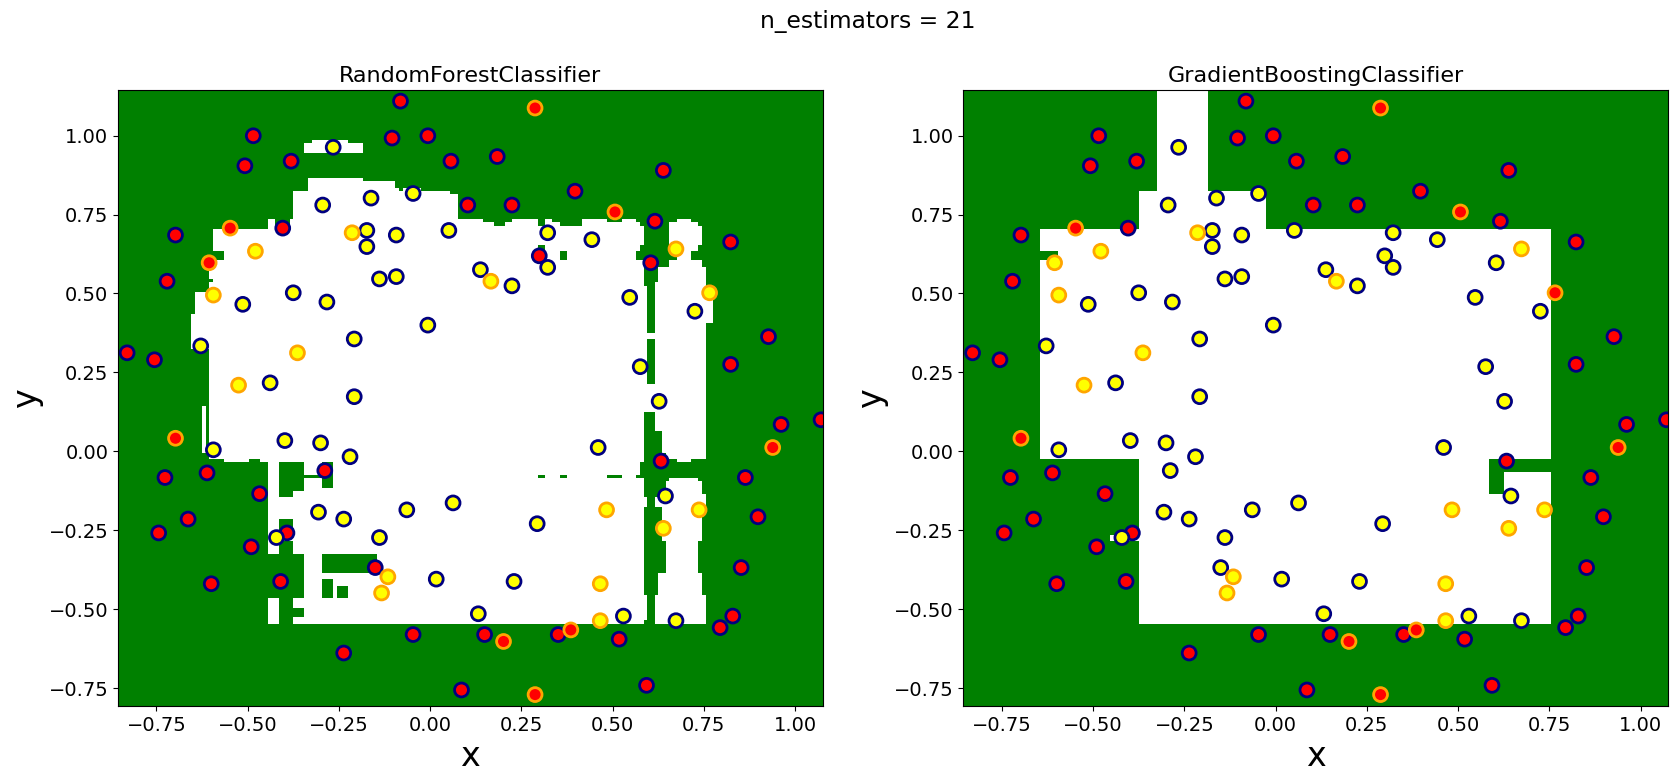

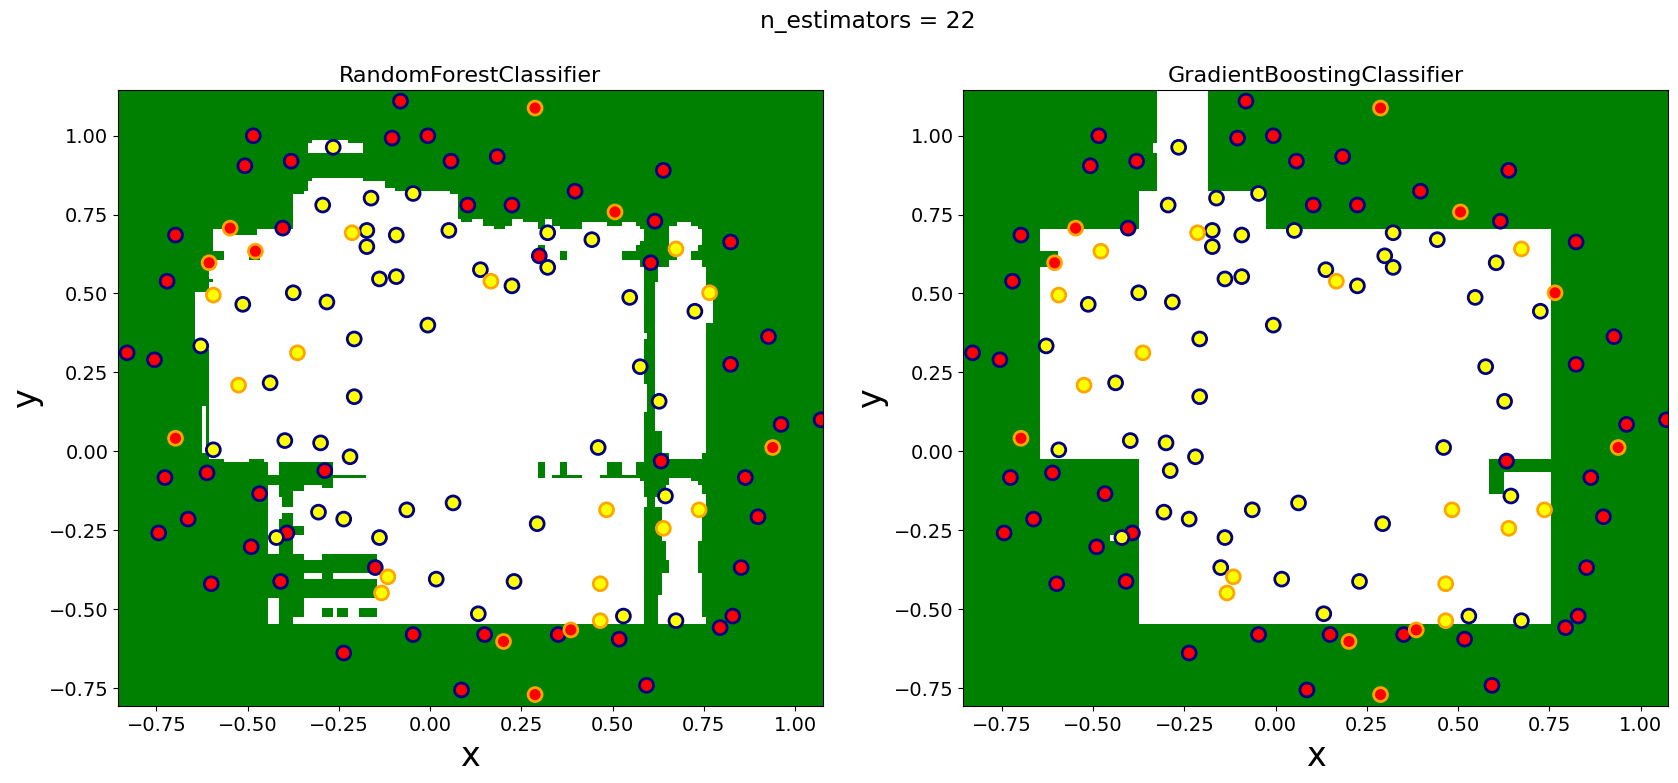

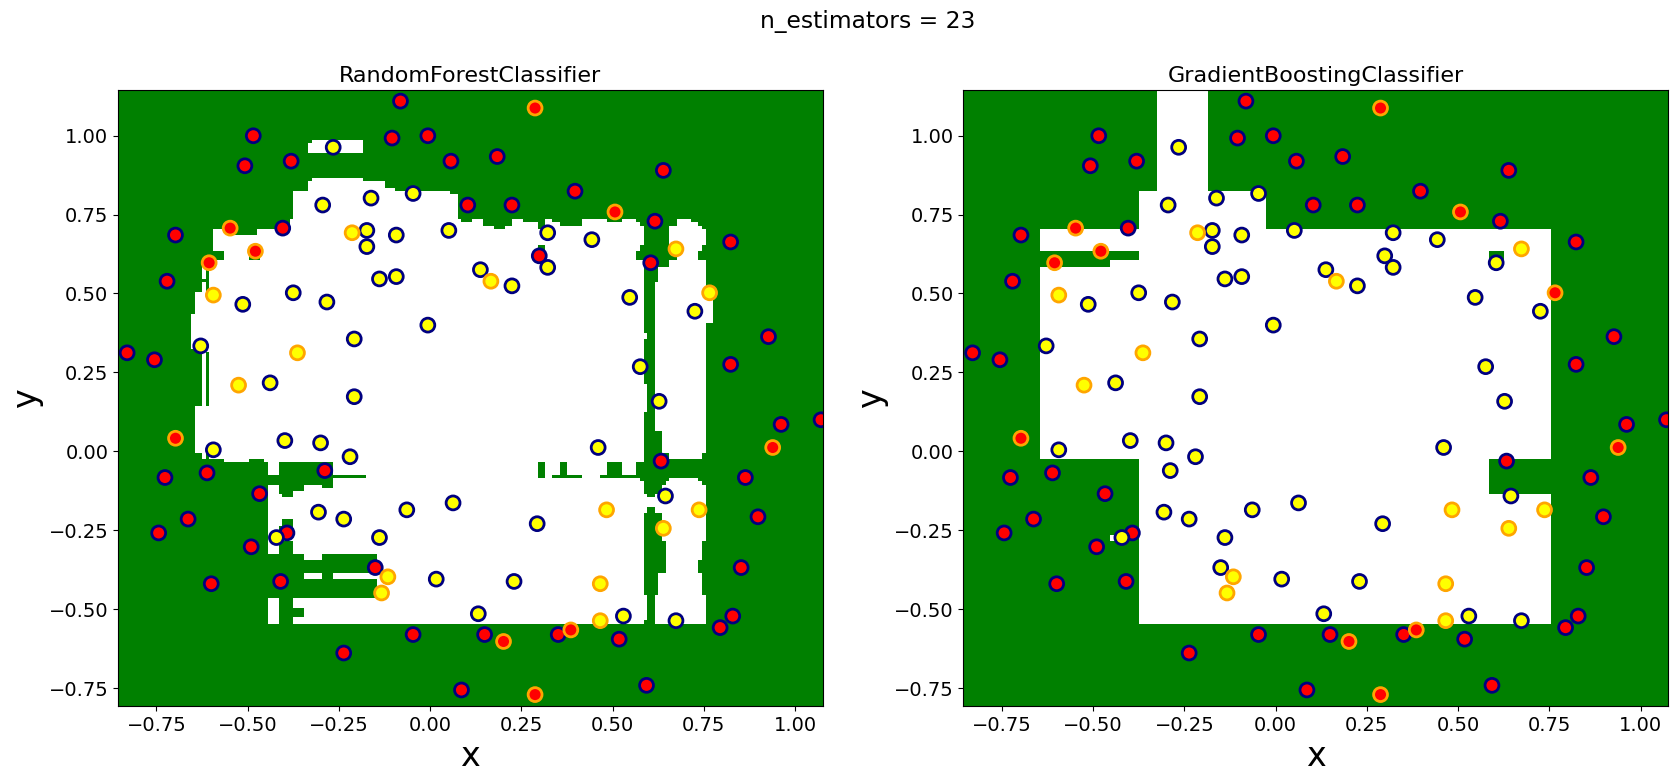

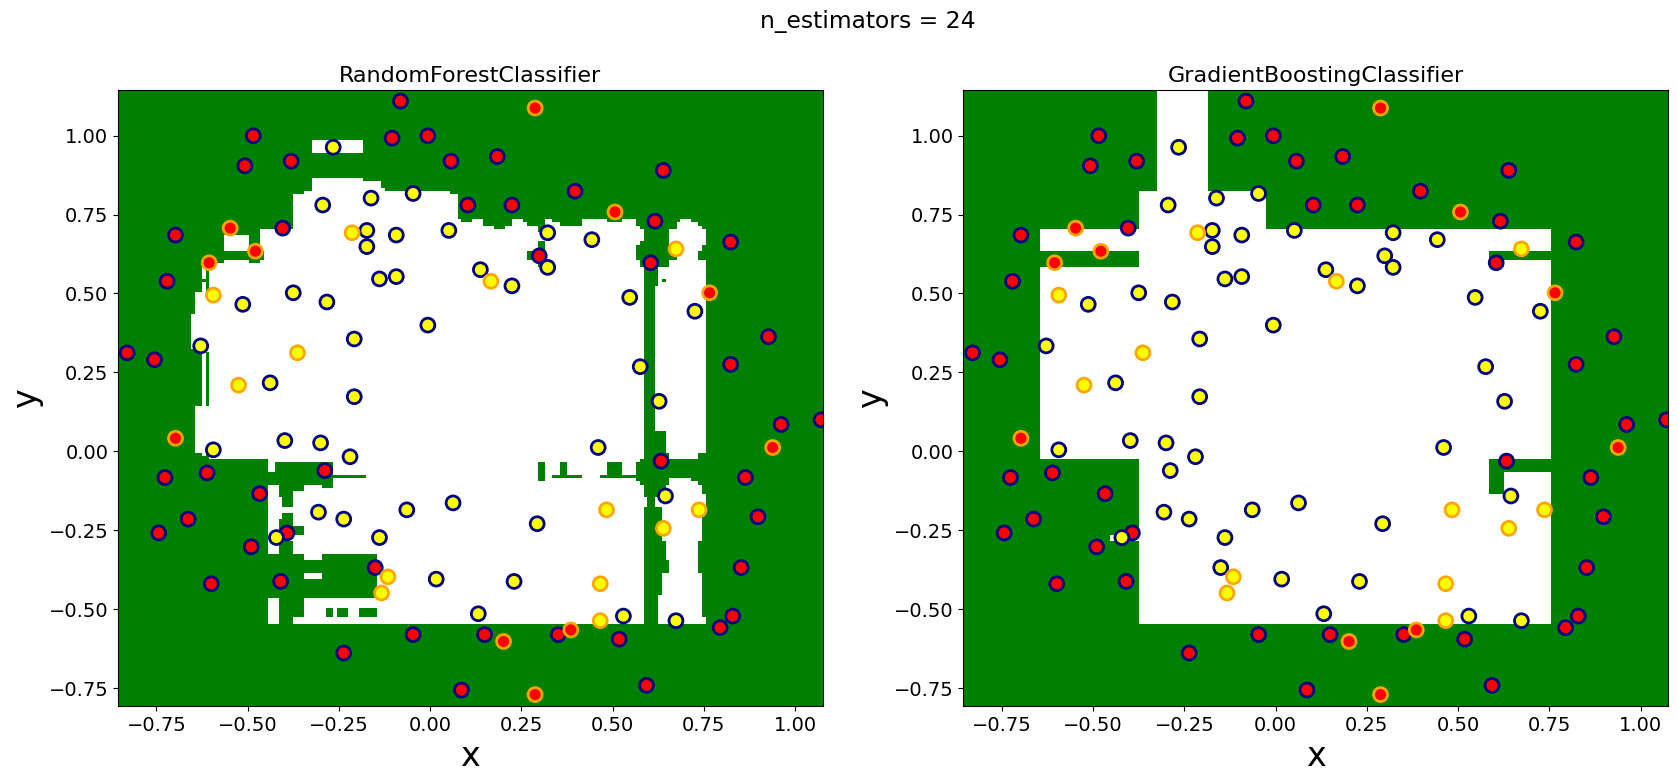

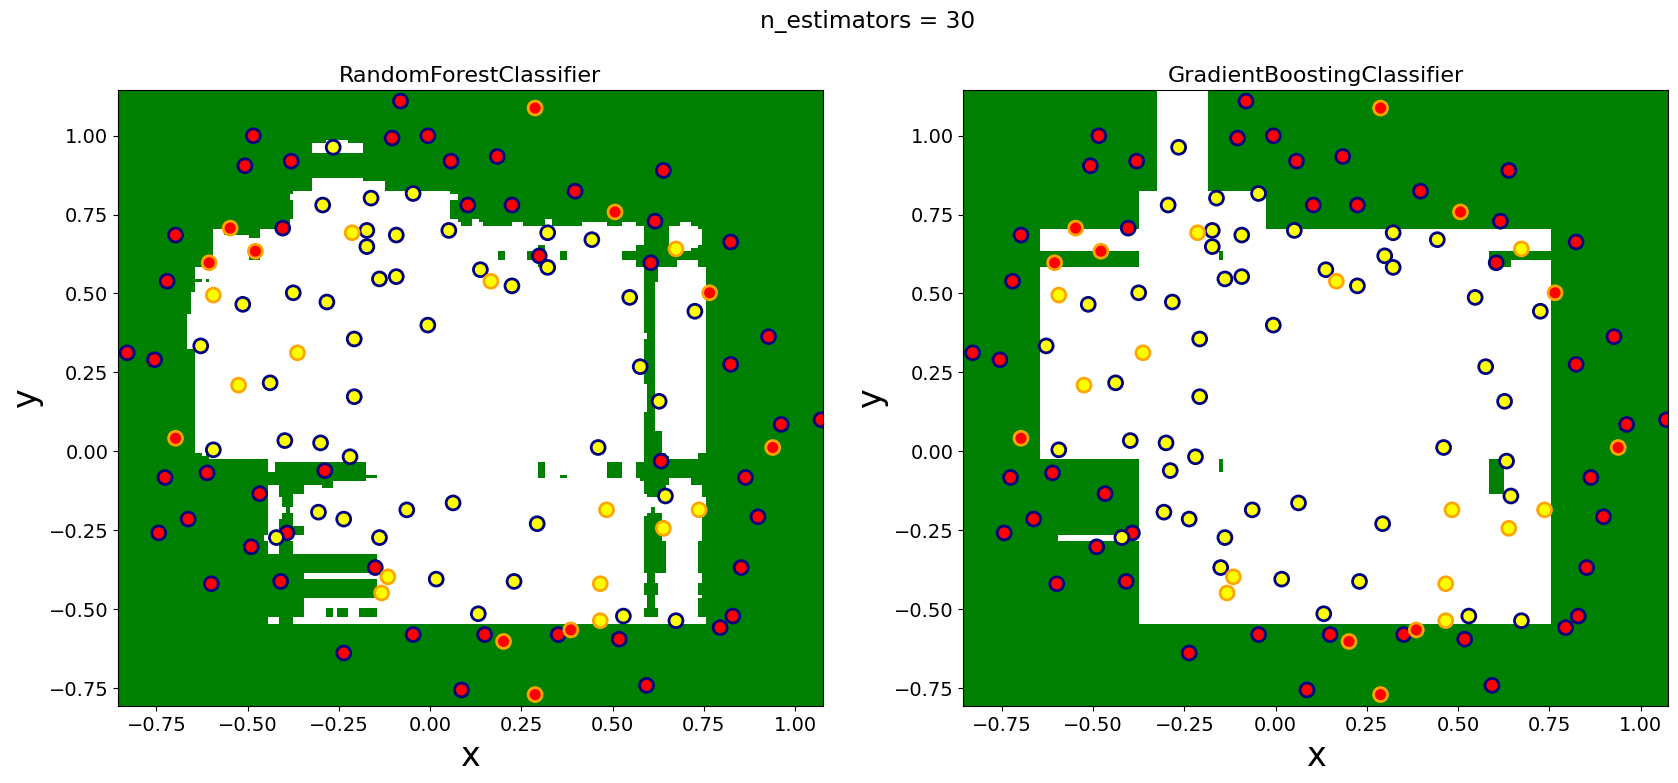

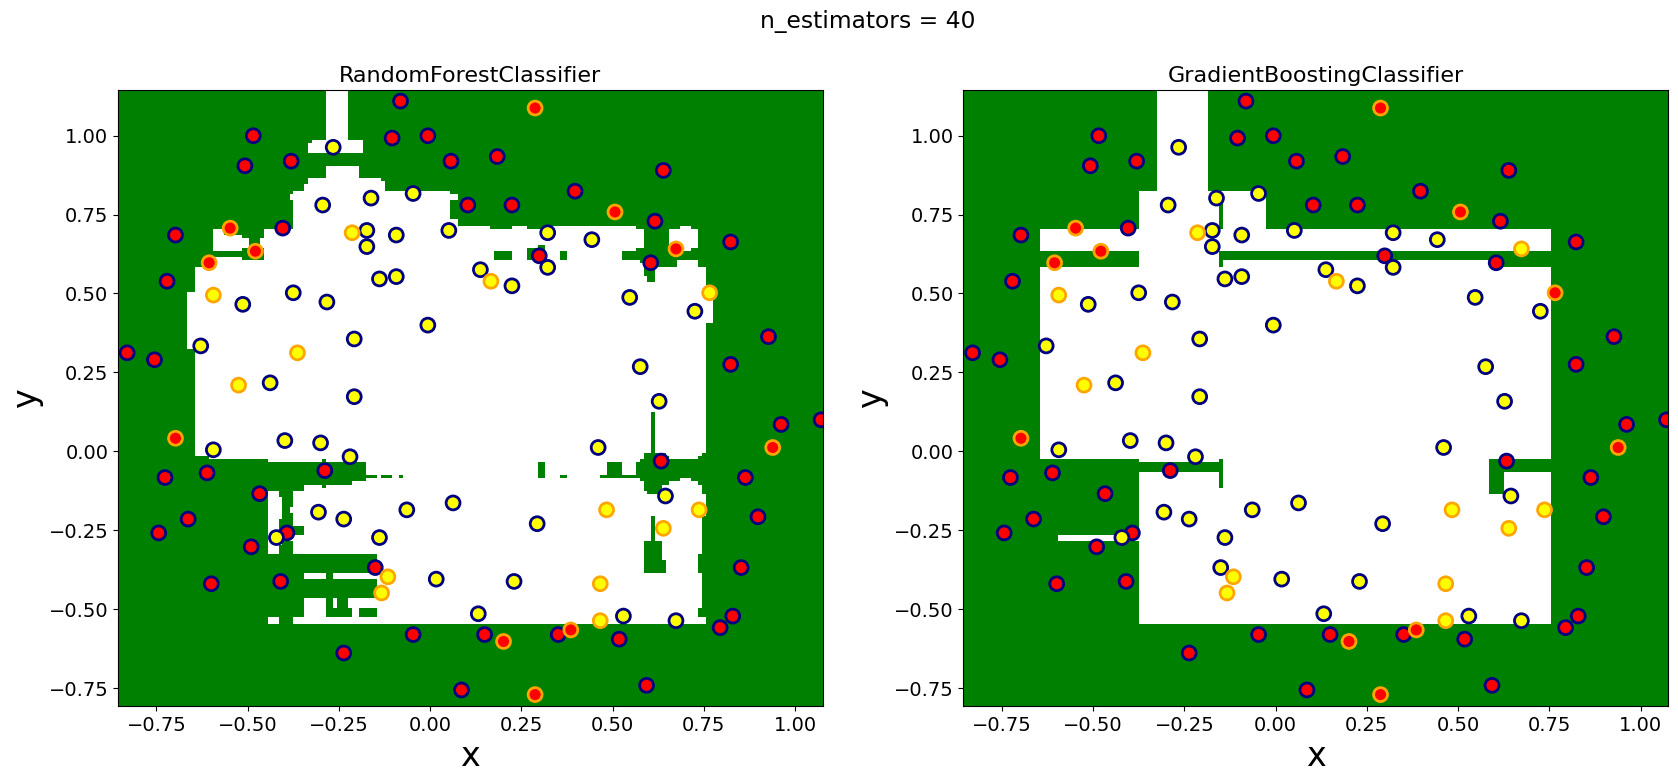

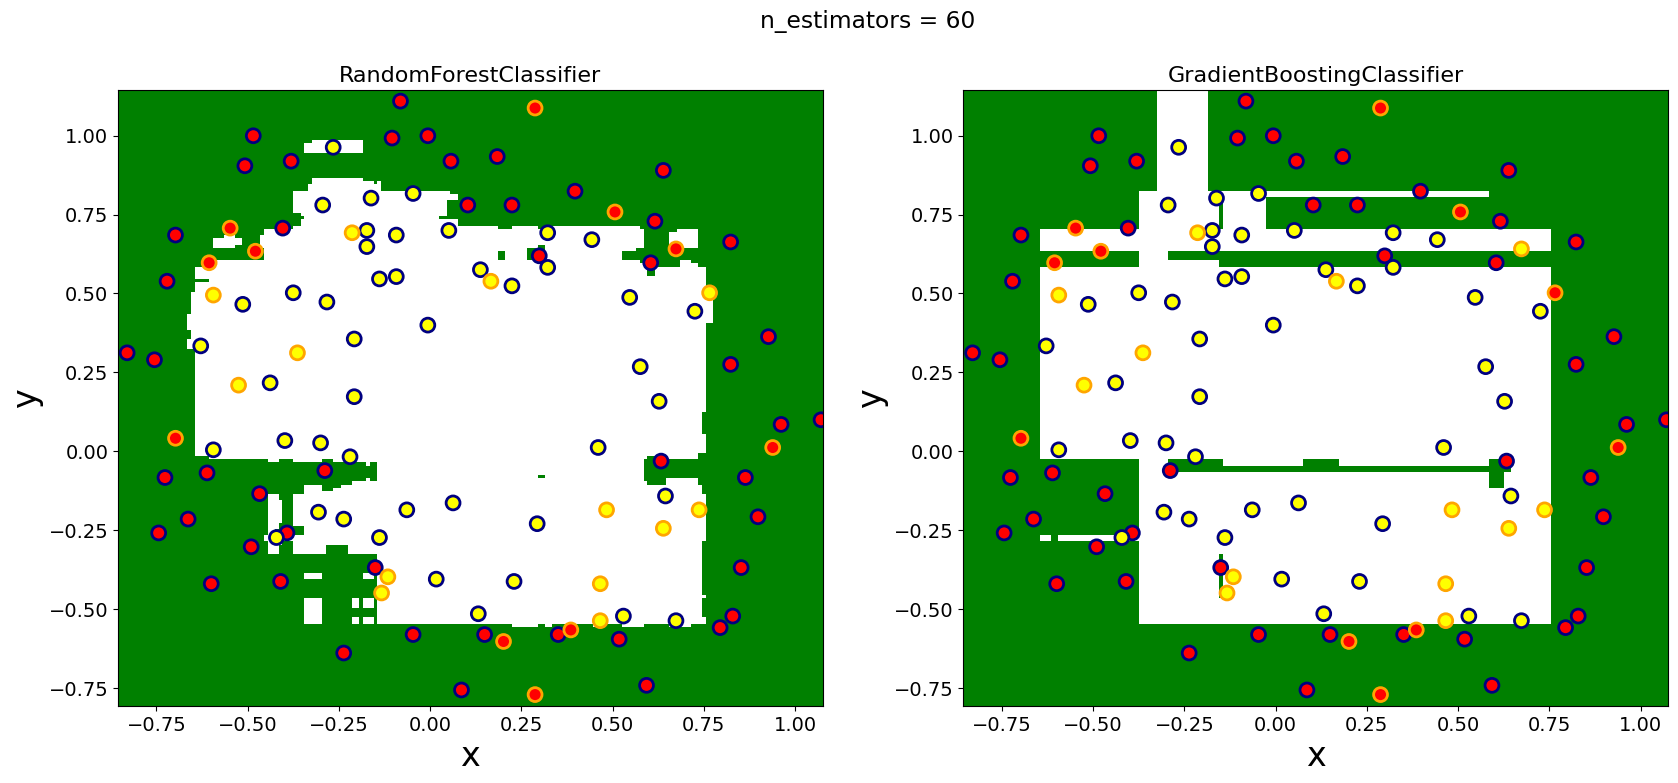

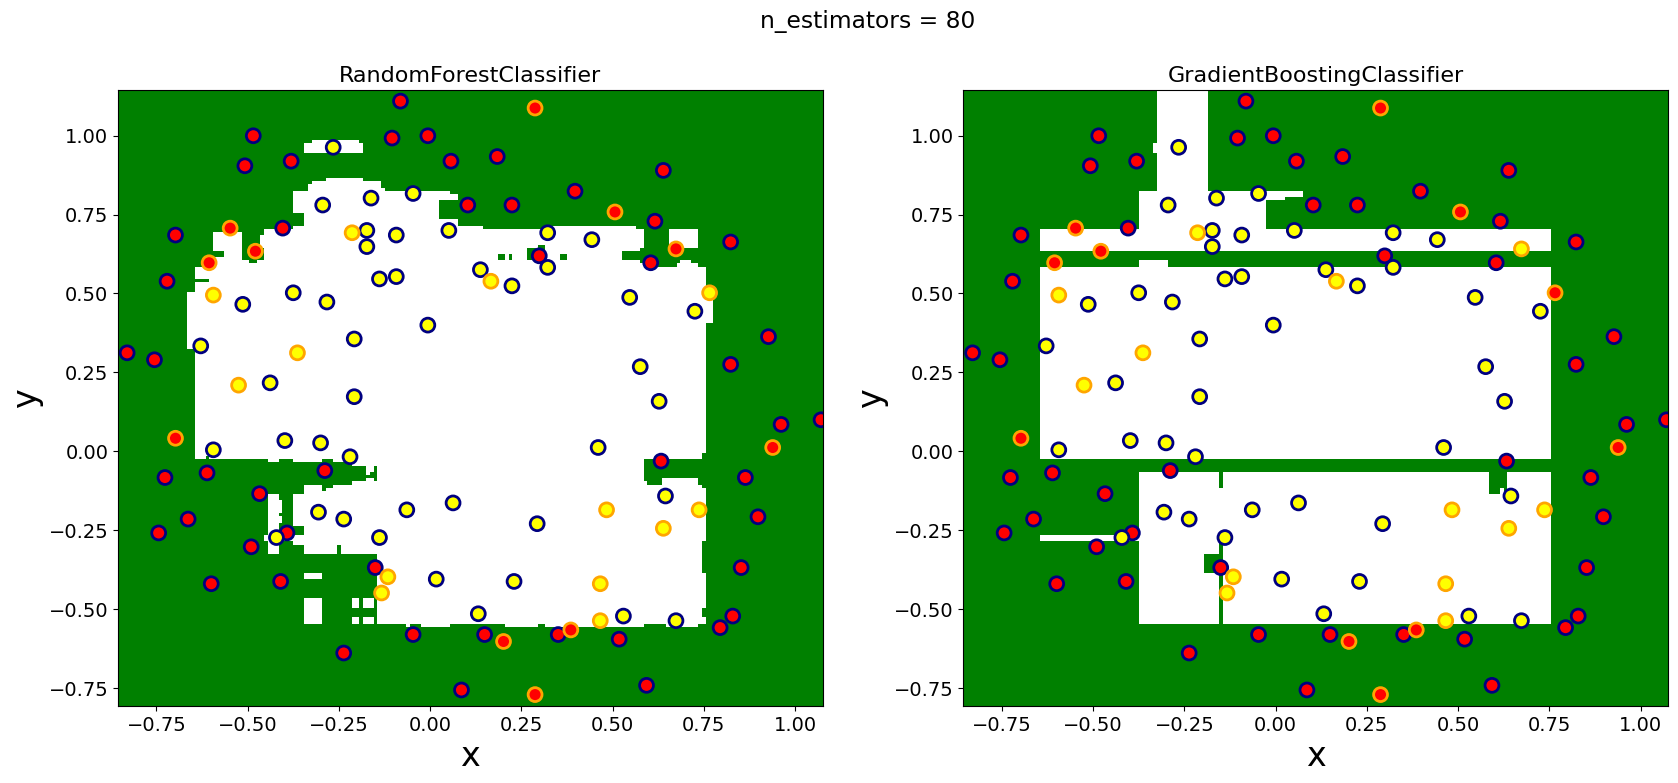

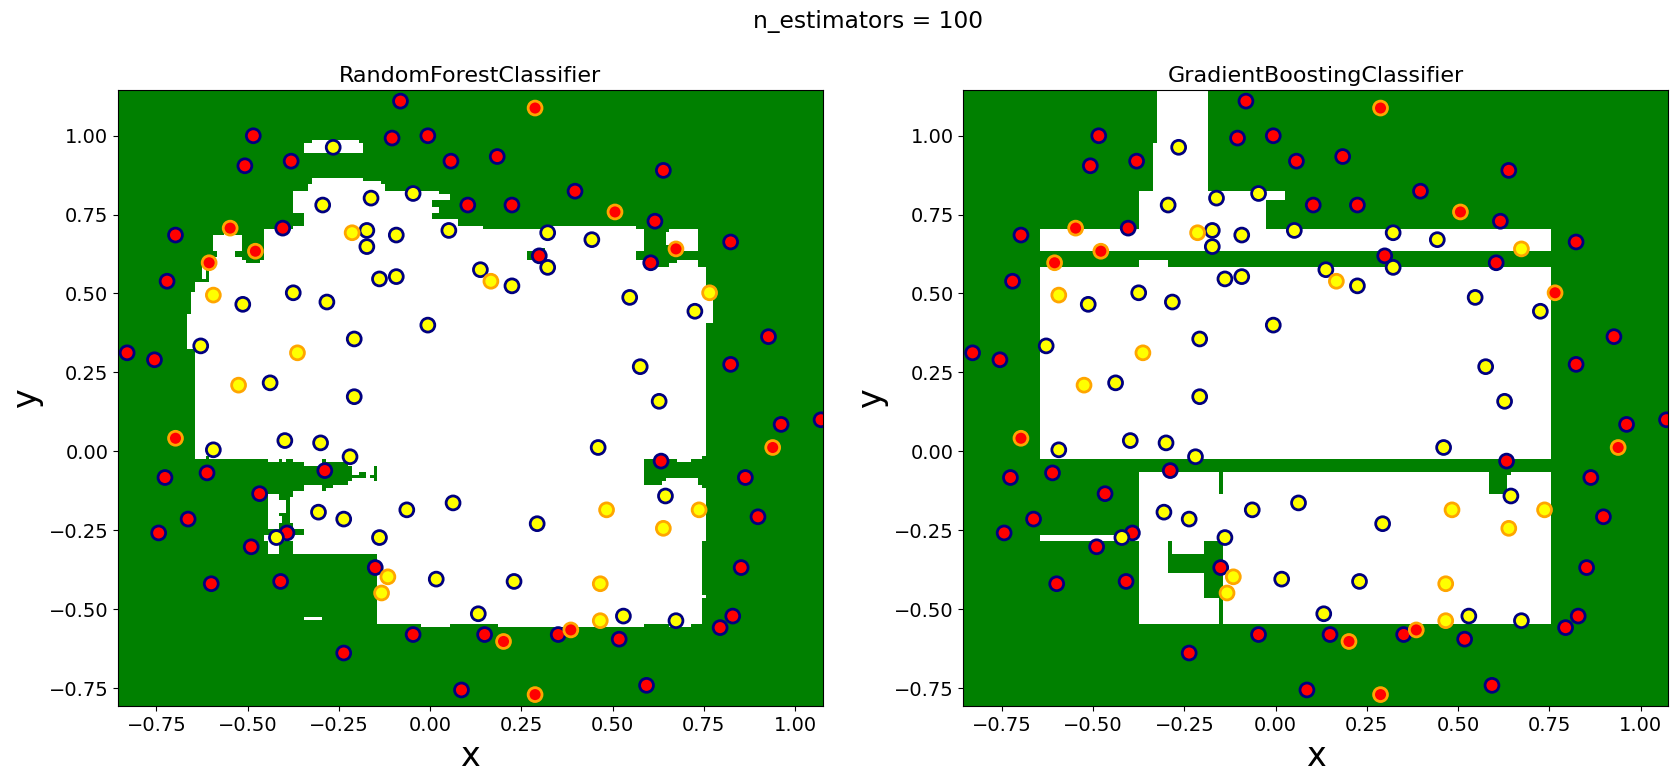

In [18]:
X_train, X_test, y_train, y_test = train_test_split(feature, y, test_size=0.2, random_state=4)
xx, yy = np.meshgrid(np.arange(-0.85, 1.08, 0.01), np.arange(-0.8, 1.15, 0.01))
plt.rcParams['font.size'] = 14

for i in range(1, 8):
    map_points(i)
map_points(14)
for i in range(20, 25):
    map_points(i)
map_points(30)
map_points(40)
map_points(60)
map_points(80)
map_points(100)
